In [ ]:

import kagglehub
import os
import shutil
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

data_path = path + "/chest_xray"
print("Path to dataset files:", data_path)


for subset in ["train", "test", "val"]:
    normal_count = len(os.listdir(os.path.join(data_path, subset, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(data_path, subset, "PNEUMONIA")))
    print(f"{subset.upper()} - NORMAL: {normal_count}, PNEUMONIA: {pneumonia_count}")

Path to dataset files: /kaggle/input/chest-xray-pneumonia/chest_xray
TRAIN - NORMAL: 1341, PNEUMONIA: 3875
TEST - NORMAL: 234, PNEUMONIA: 390
VAL - NORMAL: 8, PNEUMONIA: 8


Przeniesienie zdjęć ze zbioru treningowego do zbioru walidacyjnego, aby rozszerezyć zbiór walidacyjny

In [ ]:
import os
import shutil
# Ścieżki do katalogów
# Ścieżki źródłowe i docelowe
source_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
target_dir = '/PSI'

# Skopiuj cały katalog do kaggle/working
shutil.copytree(source_dir, target_dir, dirs_exist_ok=True)

# Teraz możesz działać w target_dir
train_normal_dir = os.path.join(target_dir, 'train/NORMAL')
train_pneumonia_dir = os.path.join(target_dir, 'train/PNEUMONIA')
val_normal_dir = os.path.join(target_dir, 'val/NORMAL')
val_pneumonia_dir = os.path.join(target_dir, 'val/PNEUMONIA')

# Funkcja przenosząca 30 plików
def move_images(source_dir, target_dir, num_files=120):
    files = os.listdir(source_dir)
    files_to_move = files[:num_files]  # wybierz pierwsze 30
    for f in files_to_move:
        shutil.move(os.path.join(source_dir, f), os.path.join(target_dir, f))
    print(f"Przeniesiono {len(files_to_move)} plików z {source_dir} do {target_dir}")

# Przenoszenie plików
move_images(train_normal_dir, val_normal_dir)
move_images(train_pneumonia_dir, val_pneumonia_dir)


Przeniesiono 120 plików z /PSI/train/NORMAL do /PSI/val/NORMAL
Przeniesiono 120 plików z /PSI/train/PNEUMONIA do /PSI/val/PNEUMONIA


Sprawdzenie poprawności przeniesienia danych.

In [ ]:
import os
data_path ='/PSI'
for subset in ["train", "test", "val"]:
    normal_count = len(os.listdir(os.path.join(data_path, subset, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(data_path, subset, "PNEUMONIA")))
    print(f"{subset.upper()} - NORMAL: {normal_count}, PNEUMONIA: {pneumonia_count}")

TRAIN - NORMAL: 1221, PNEUMONIA: 3755
TEST - NORMAL: 234, PNEUMONIA: 390
VAL - NORMAL: 128, PNEUMONIA: 128


Wyświetlenie przykładowych obrazów

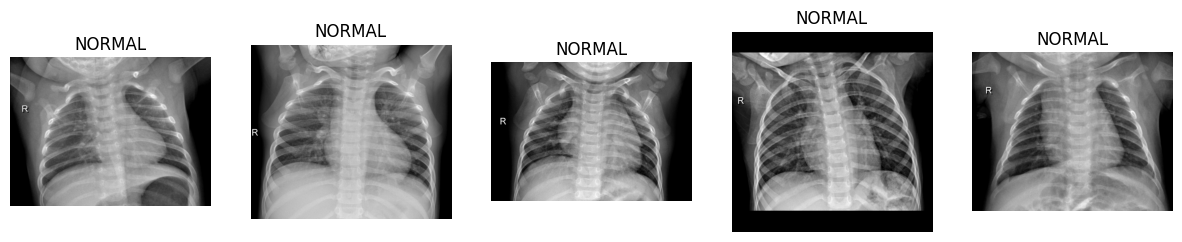

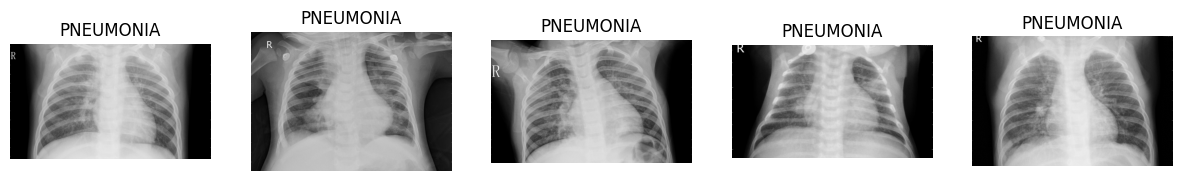

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

def show_sample_images(category, subset="train"):
    folder = os.path.join(data_path, subset, category)
    images = random.sample(os.listdir(folder), 5)  # Losowe 5 obrazów
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, img in enumerate(images):
        img_path = os.path.join(folder, img)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(image, cmap='gray')
        axes[i].axis("off")
        axes[i].set_title(category)
    plt.show()

show_sample_images("NORMAL")
show_sample_images("PNEUMONIA")

Przypisanie etykiet zdjęciom dla zbioru treningowego:

In [ ]:
import pandas as pd

filepath = []
label = []

# ścieżka do folderu ze zbiorem treningowym
train_data_path = data_path+"/train"

folders = os.listdir(train_data_path)

for folder in folders:
    folder_path = os.path.join(train_data_path , folder)
    images = os.listdir(folder_path)

    for image in images:
        img_path = os.path.join(folder_path , image)
        filepath.append(img_path)
        label.append(folder)

# Przypisanie etykiet do konkretnych zdjęć
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

Sprawdzenie poprwaności przypisania labels.

In [ ]:
Label_path_series

,label
0,PNEUMONIA
1,PNEUMONIA
2,PNEUMONIA
3,PNEUMONIA
4,PNEUMONIA
...,...
4971,NORMAL
4972,NORMAL
4973,NORMAL
4974,NORMAL


In [ ]:
df_train

,filepath,label
0,/PSI/train/PNEUMONIA/person507_bacteria_2141.jpeg,PNEUMONIA
1,/PSI/train/PNEUMONIA/person1657_bacteria_4398....,PNEUMONIA
2,/PSI/train/PNEUMONIA/person1557_bacteria_4063....,PNEUMONIA
3,/PSI/train/PNEUMONIA/person1231_virus_2088.jpeg,PNEUMONIA
4,/PSI/train/PNEUMONIA/person749_virus_1374.jpeg,PNEUMONIA
...,...,...
4971,/PSI/train/NORMAL/NORMAL2-IM-0554-0001.jpeg,NORMAL
4972,/PSI/train/NORMAL/NORMAL2-IM-0907-0001.jpeg,NORMAL
4973,/PSI/train/NORMAL/IM-0590-0001.jpeg,NORMAL
4974,/PSI/train/NORMAL/IM-0627-0001.jpeg,NORMAL


In [ ]:
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy

Tworzenie zestawów danych. Obrazy będą przeskalowane do rozmiaru 256×256 pikseli. Jest to ważne, ponieważ modele sieci neuronowych wymagają jednolitego rozmiaru wejściowego.

`image_dataset_from_directory(...)` automatycznie tworzy zbiór danych z folderów. Wykrywa podkatalogi jako klasy i oznacza obrazy odpowiednimi etykietami.

`validation_split=0.1` – oznacza, że 10% danych zostanie użytych do walidacji.

`seed=123` - ustawienie ziarna dla losowego podziału, aby eksperyment był powtarzalny.

`batch_size=32` – dane będą ładowane w paczkach po 32 obrazy.


In [ ]:
val_data_path = '/PSI/val'
test_data_path = '/PSI/test'
train_data_path = "/PSI/train"
IMAGE_SIZE = (512,512)

# Tworzenie zestawu danych treningowych

print('Training imgs:')
train_df = tf.keras.utils.image_dataset_from_directory(
    train_data_path,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32,
    )

# Tworzenie zestawu danych testowych

print('Testing Images:')
test_df = tf.keras.utils.image_dataset_from_directory(
    test_data_path,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32,
    label_mode='int',          # jeśli test ma etykiety; inaczej 'none'
    )


# Tworzenie zestawu danych walidacyjnych

print('Validation imgs:')
validation_df = tf.keras.utils.image_dataset_from_directory(
    val_data_path,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32,
    )

Training imgs:
Found 4976 files belonging to 2 classes.
Using 4479 files for training.
Testing Images:
Found 624 files belonging to 2 classes.
Validation imgs:
Found 256 files belonging to 2 classes.


Pobranie 10 batchy ze zbioru treningowego - wydruk pokazuje następująco (32, 768, 768 ,3) - odpowiada to ilości zdjęć w batchu tutaj 32 - rozmiary zdjęć, tutaj 768x768 pikseli oraz 3 - ilość kanałów RGB a poniżej [1,0,1,0,1,1] - to tensor określający czy dane zdjęcie jest z kateogrii PNEUMONIA - 1, czy NORMAL - 0 - tensorflow konwertuje nazwy  folderów na wartości 0,1 automatycznie.

In [ ]:
for images, labels in train_df.take(5):
    print(images.shape)  # (32, height, width, 3)
    print(labels.numpy())  # np. [0 1 0 0 1 1 ...]

(32, 512, 512, 3)
[1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1]
(32, 512, 512, 3)
[1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1]
(32, 512, 512, 3)
[1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1]
(32, 512, 512, 3)
[0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
(32, 512, 512, 3)
[1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1]


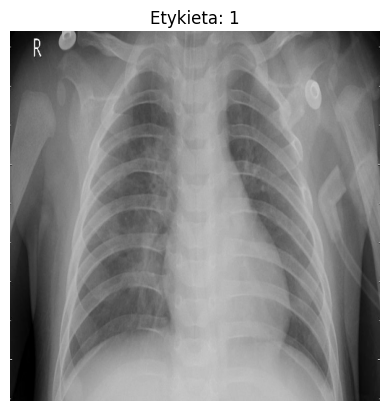

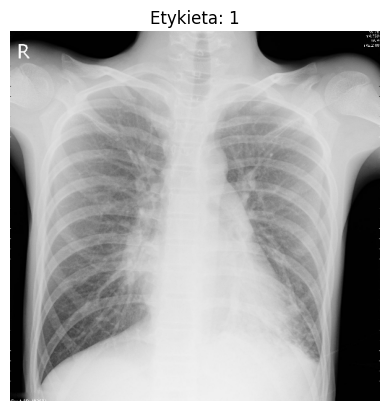

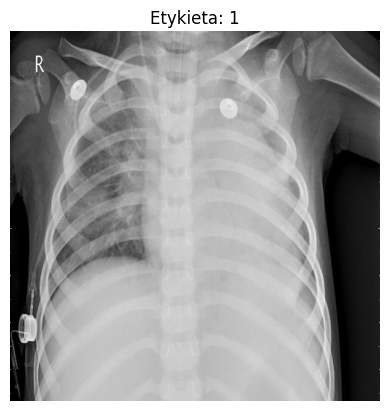

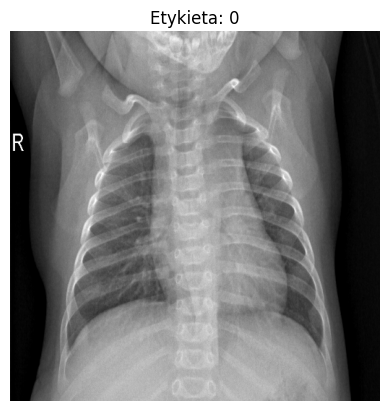

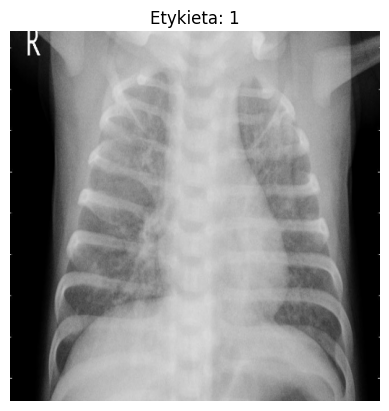

In [ ]:
import matplotlib.pyplot as plt

# Podgląd 5 przykładowych obrazów po augmentacji
for images, labels in train_df.take(1):
    for i in range(5):
        img = images[i].numpy()  # obraz po augmentacji w 0–1
        #img = img * 255.0        # przeskaluj do 0–255
        img = img.astype("uint8")
        plt.figure()
        plt.imshow(img)
        plt.title(f"Etykieta: {labels[i].numpy()}")
        plt.axis('off')
        plt.show()

Normalizacja wartości pikseli.

Obrazy mają wartości pikseli w zakresie 0–255.

Normalizowane są do zakresu 0–1, dzieląc przez 255.0.

Model lepiej uczy się na wartościach 0-1 dlatego powinno to zwiększyć skuteczność modelu.

In [ ]:
# Normalizacja wartości pikseli

# Train
train_df = train_df.map(lambda x, y: (x / 255.0, y))

# Val
validation_df = validation_df.map(lambda x, y: (x / 255.0, y))

# Test
test_df = test_df.map(lambda x, y: (x / 255.0, y))

In [ ]:
for images, labels in train_df.take(1):
    print(f"Piksele (min): {tf.reduce_min(images).numpy()}")
    print(f"Piksele (max): {tf.reduce_max(images).numpy()}")
    print(f"Etykiety: {labels.numpy()}")

Piksele (min): 0.0
Piksele (max): 1.0
Etykiety: [1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0]


Próba augmentacji - augmentacja to zabieg który ma niejako "sztucznie" poszerzyć zbiór modyfikując nieznacznie posiadane dane(zdjęcia) zmieniając lekko ich kontrast, przybliżenie i sprawia że dane są podobne jednak nie takie same. Powinno to poprawić performence modelu oraz także zapobiega zjawisku overfittingu - czyli kiedy model bardzo dobrze radzi sobie z danymi testowymi jednak nie potrafi generalizować, czyli poprawnie robić predykcje dla obrazów spoza zbioru testowego.


In [ ]:
# Definiujemy warstwy augmentacji
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.11),           # Powiększenie/zmniejszenie max o 11%
    tf.keras.layers.RandomContrast(0.15)        # Zmienność kontrastu o 15%
])

# Zastosowanie augmentacji tylko do zbioru treningowego
train_df2 = train_df.map(lambda x, y: (data_augmentation(x, training=True), y))

Po augmentacji wyświetlamy kilka losowo wybranych zmienionych obrazów.

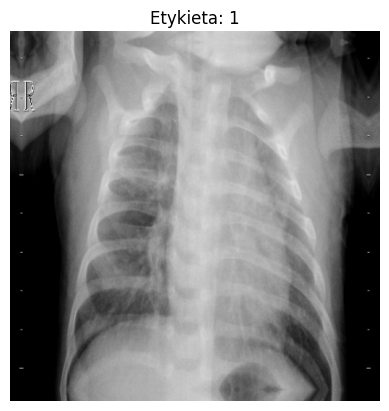

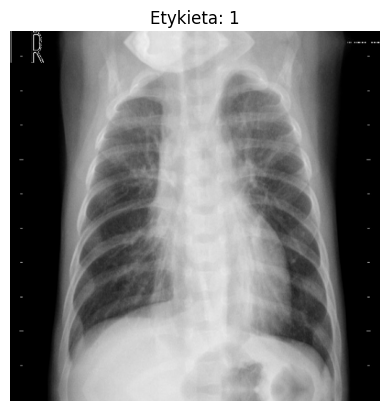

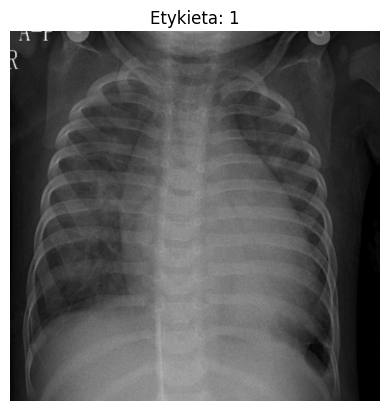

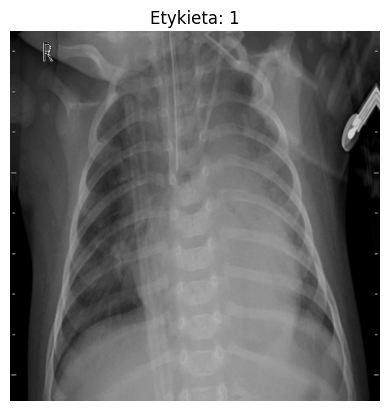

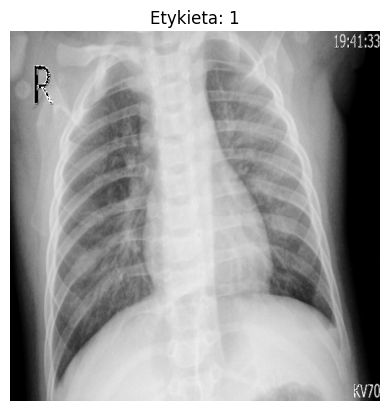

In [ ]:
for images, labels in train_df2.take(1):
    for i in range(5):
        img = images[i].numpy()  # obraz po augmentacji w 0–1
        img = img * 255.0        # przeskaluj do 0–255
        img = img.astype("uint8")
        plt.figure()
        plt.imshow(img)
        plt.title(f"Etykieta: {labels[i].numpy()}")
        plt.axis('off')
        plt.show()

Tworzenie modelu konwolucyjnego - tego rodzaju sieci są najlepsze dla analizy obrazów. Sieć łączy wartwy konwolucyjne wraz z MaxPoolingiem, który sprowadza się niejako do zmniejszania wejściowego rozmiaru obrazu wyłapując najbardziej aktywne piksele i niejako 'odszumiając' obraz.

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,073,601 (240.61 MB)

 Trainable params: 63,073,601 (240.61 MB)

 Non-trainable params: 0 (0.00 B)

Trening Modelu B (dwufazowy)
Poniższy kod trenuje Model B w dwóch fazach: najpierw na oryginalnym zbiorze train_df, a następnie kontynuuje trening na augmentowanym zbiorze train_df2. Zakładamy, że train_df oraz train_df2 są obiektami typu tf.data.Dataset lub podobnymi (np. z image_dataset_from_directory lub ImageDataGenerator.flow(...)), a val_df to zbiór walidacyjny. Po każdej fazie wypisujemy uzyskaną dokładność na walidacji.

In [ ]:
# Trening faza 1: na zbiorze train_df (dane oryginalne, znormalizowane)
epochs_phase1 = 5  # liczba epok dla fazy 1 (przykładowo)
history1 = model.fit(train_df,
                      epochs=epochs_phase1,
                      validation_data=validation_df)

# Dokładność walidacyjna po fazie 1
val_acc_phase1 = history1.history['val_accuracy'][-1]
print(f"Model B - walidacyjna dok\u0142adno\u015b\u0107 po fazie 1: {val_acc_phase1:.4f}")




Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 87s 480ms/step - accuracy: 0.8056 - loss: 0.5927 - val_accuracy: 0.9375 - val_loss: 0.1553
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 48s 342ms/step - accuracy: 0.9608 - loss: 0.1065 - val_accuracy: 0.9805 - val_loss: 0.0669
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 325ms/step - accuracy: 0.9651 - loss: 0.0895 - val_accuracy: 0.9766 - val_loss: 0.0812
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - accuracy: 0.9858 - loss: 0.0469 - val_accuracy: 0.9688 - val_loss: 0.1405
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 325ms/step - accuracy: 0.9751 - loss: 0.0652 - val_accuracy: 0.9766 - val_loss: 0.1672
Model B - walidacyjna dokładność po fazie 1: 0.9766


In [ ]:
# Trening faza 2: kontynuacja na zbiorze train_df2 (dane augmentowane)
epochs_phase2 = 5  # liczba epok dla fazy 2 (np. kolejne 5 epok)
history2 = model.fit(train_df2,
                      epochs=epochs_phase2,
                      validation_data=validation_df)

# Dokładność walidacyjna po fazie 2
val_acc_phase2 = history2.history['val_accuracy'][-1]
print(f"Model B - walidacyjna dok\u0142adno\u015b\u0107 po fazie 2: {val_acc_phase2:.4f}")

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9504 - loss: 0.1416 - val_accuracy: 0.9609 - val_loss: 0.0875
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9554 - loss: 0.1142 - val_accuracy: 0.9336 - val_loss: 0.1298
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9621 - loss: 0.1099 - val_accuracy: 0.9453 - val_loss: 0.1063
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9708 - loss: 0.0815 - val_accuracy: 0.9648 - val_loss: 0.1045
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9731 - loss: 0.0785 - val_accuracy: 0.9492 - val_loss: 0.1038
Model B - walidacyjna dokładność po fazie 2: 0.9492


Walidacja modelu po treningu:


In [ ]:
# ------- OFICJALNY SCORE WALIDACYJNY -------
val_loss, val_acc = model.evaluate(validation_df, verbose=1)
print(f"\nWalidacja po dwóch etapach ➜ loss: {val_loss:.4f} | accuracy: {val_acc:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step - accuracy: 0.9507 - loss: 0.1177

Walidacja po dwóch etapach ➜ loss: 0.1038 | accuracy: 0.9492


Sprawdzenie modelu na danych testowych

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
IMAGE_SIZE = (512,512)
TEST_DIR = '/PSI/test'

# 1. surowy dataset (shuffle=False, batch_size=None => po 1 pliku)
test_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode='int',
    shuffle=False,
    image_size = IMAGE_SIZE,
    batch_size=None)     # każdy element to (img, label)

file_paths = test_raw.file_paths           # ścieżki 1-do-1
class_names = test_raw.class_names         # ['normal', 'pneumonia', ...]

# 2. pipeline (normalizacja + batch)
test_df = (test_raw
           .map(lambda x, y: (x/255.0, y))
           .batch(32)
           .prefetch(tf.data.AUTOTUNE))

# 3. predykcje
y_prob = model.predict(test_df, verbose=1).squeeze()
y_pred = (y_prob > 0.7).astype(int)
y_pred_labels = [class_names[i] for i in y_pred]

# 4. prawdziwe etykiety
y_true = np.concatenate([y for _, y in test_df], axis=0)
y_true_idx = y_true if y_true.ndim == 1 else np.argmax(y_true, axis=1)
y_true_labels = [class_names[i] for i in y_true_idx]

# 5. DataFrame
results_df = pd.DataFrame({
    'file': [Path(p).name for p in file_paths],
    'true_label': y_true_labels,
    'pred_label': y_pred_labels,
    'probability': y_prob
})

# 6. trafienia
correct = (results_df['pred_label'] == results_df['true_label']).sum()
total   = len(results_df)
print(f'Trafienia: {correct}/{total}  (accuracy = {correct/total:.2%})')
print(results_df.head())

# 7. zapis CSV
results_df.to_csv('/content/predictions_test.csv', index=False)

NotFoundError: Could not find directory /PSI/test